### Fourier Neural Operator (FNO): Solving a ODE for different right hand sides
In this notebook, we present an introduction to the FNO [(paper)](https://arxiv.org/abs/2010.08895) utilities of TorchPhysics. 
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions $f$. 

In [1]:
import torch 
import torchphysics as tp
import pytorch_lightning as pl

First create the data set we need for training the network.
Here we randomly create some oscillating functions and use an explicit euler to compute our training data.

In [2]:
N_batch = 5000 # Data in trainig set
N_time = 100 # resolution of time (or space) interval
dt = 1/N_time

input_data = torch.zeros((N_batch, N_time, 1))
random_data = torch.zeros((N_batch, 3))
random_data[:, :1] = torch.randint(0, 24, (N_batch, 1))
random_data[:, 1:2] = torch.randint(0, 12, (N_batch, 1))
random_data[:, 2:] = torch.randint(0, 6, (N_batch, 1))

output_data = torch.zeros((N_batch, N_time, 1))

t = 0.0
input_data[:, 0, 0] = torch.sin(t * random_data[:, 0]) + 0.5 * torch.cos(t * random_data[:, 1]) \
                        + 2.0 * torch.sin(t * random_data[:, 2])
for i in range(1, N_time):
    t += dt
    input_data[:, i, 0] = torch.sin(t * random_data[:, 0]) + 0.5 * torch.cos(t * random_data[:, 1]) \
                        + 2.0 * torch.sin(t * random_data[:, 2])
    output_data[:, i, 0] = output_data[:, i-1, 0] + dt * input_data[:, i, 0]

In TorchPhysics we have to define the input and output space like always:

In [3]:
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

Next we create the network that learns the mapping:

In [4]:
hidden_channels = 8

model = tp.models.FNO(F, U, 
                      fourier_layers=3, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=8, 
                      skip_connections=True, 
                      channel_down_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, U.dim)
                      ))

Now we create a data condition to fit the FNO to the data.

In [5]:
# Transform data to points
input_data_points = tp.spaces.Points(input_data, F)
output_data_points = tp.spaces.Points(output_data, U)

dataloader = tp.utils.PointsDataLoader((input_data_points, output_data_points),
                                       batch_size=N_batch)

data_condition = tp.conditions.DataCondition(model, dataloader, norm=2)

Start training:

In [6]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.01)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 505   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_l

Epoch 0: 100%|██████████| 5000/5000 [00:47<00:00, 104.95it/s, train/loss=0.00127] 

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [00:47<00:00, 104.95it/s, train/loss=0.00127]


Decrease learning rate and fine tune some more:

In [7]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=10000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]



  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 505   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 10000/10000 [01:31<00:00, 108.78it/s, train/loss=0.000454]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [01:31<00:00, 108.78it/s, train/loss=0.000454]


Next we test the network on unseen data. Therefore we create inputs as before and evaluate the model:

In [8]:
N_test = 100
N_time = 100
dt = 1/N_time

test_data = torch.zeros((N_test, N_time, 1))
output_data_test = torch.zeros((N_test, N_time, 1))

random_data = torch.zeros((N_test, 3))
random_data[:, :1] = torch.randint(0, 24, (N_test, 1))
random_data[:, 1:2] = torch.randint(0, 12, (N_test, 1))
random_data[:, 2:] = torch.randint(0, 6, (N_test, 1))

t = 0.0
test_data[:, 0, 0] = torch.sin(t * random_data[:, 0]) + 0.5 * torch.cos(t * random_data[:, 1]) \
                        + 2.0 * torch.sin(t * random_data[:, 2])
for i in range(1, N_time):
    t += dt
    test_data[:, i, 0] = torch.sin(t * random_data[:, 0]) + 0.5 * torch.cos(t * random_data[:, 1]) \
                            + 2.0 * torch.sin(t * random_data[:, 2])
    output_data_test[:, i, 0] = output_data_test[:, i-1, 0] + dt * test_data[:, i, 0]

model_output = model(tp.spaces.Points(test_data, F)).as_tensor

rel_error = torch.max(torch.abs(model_output - output_data_test)) / torch.max(output_data_test)

print(f"Relative error: {rel_error*100} %")

Relative error: 11.572426795959473 %


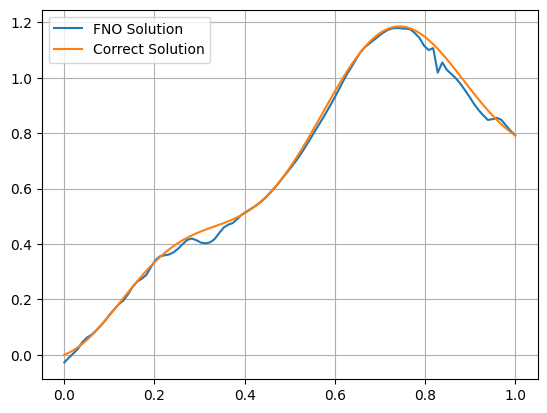

In [9]:
import matplotlib.pyplot as plt

example_plot = 6
t = torch.linspace(0, 1, N_time)
plt.plot(t, model_output[example_plot, :, 0].detach().cpu())
plt.plot(t, output_data_test[example_plot, :, 0].detach().cpu())
plt.legend(["FNO Solution", "Correct Solution"])
plt.grid()